In [107]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 

from sklearn.model_selection import train_test_split

In [2]:
df = sb.load_dataset("iris") 
print(df.head()) 
print(df.info())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


In [39]:
class node:
    def __init__(self,isLeaf,leafVal, featureNo, threshold,left,right):
        self.isLeaf=isLeaf 
        self.leafVal=leafVal 
        self.featureNo=featureNo 
        self.threshold=threshold 
        self.left=left 
        self.right=right 
    

In [40]:
def entropy(Y):
    labels=np.unique(Y) 
    n=len(Y)
    count={}
    for l in labels:
        count[l]=0
    for y in Y:
        count[y]+=1
    result=0
    for  l in labels:
        p=count[l]/n
        result-=(p*np.log(np.clip(p,1e-15,1-1e-15)))
    return result

entropy(df["species"].values[0:52])

np.float64(0.16302362949436594)

In [41]:
Xdf = df.drop("species",axis=1)
Ydf = df["species"]




In [139]:
MIN_ENTROPY = 0.163
MIN_CHANGE = 0.05
MAX_DEPTH = 10 

def findMaxCount(Y):
    labels=np.unique(Y) 
    result=Y[0]
    count=0
    for l in labels:
        c=list(Y).count(l) 
        if(c>count):
            result=l 
            count=c 
    return result 

def makeTree(X,Y,depth):
    # return leaf node if depth is too much or data size is too small 
    pe = entropy(Y)
    if(pe<=MIN_ENTROPY or depth>=MAX_DEPTH or len(Y)<=3):
        return node(True,findMaxCount(Y),0,0,None,None)
    n=X.shape[0]
    L=X.shape[1]
    optimalLabel=0
    optimalThreshold=X[0][0]
    minEntropy=1e15
    lrIndex=0
    for l in range(L):
        Xl = [(X[i],Y[i]) for i in range(n)]
        Xl = sorted(Xl, key=lambda a:a[0][l])
        Yl = np.array([xl[1] for xl in Xl])
        Xl = np.array([xl[0] for xl in Xl])
        threshold=Xl[0][l] 
        # print(threshold)
        minE=1e15
        lr = 0
        for i in range(1,n):
            if(Xl[i][l]==Xl[i-1][l]):
                continue
            E1 = entropy(Yl[0:i])
            E2 = entropy(Yl[i:n])
            E = (((i)*E1)+((n-i)*E2))/n
            if(E<minE):
                minE = E 
                threshold = Xl[i-1][l]
                lr = i
        if(minE<minEntropy):
            minEntropy=minE 
            optimalThreshold=threshold 
            optimalLabel=l
            lrIndex=lr
    if(lrIndex==0 or pe-minEntropy < MIN_CHANGE):
        return node(True,findMaxCount(Y),0,0,None,None)
    Xl = [(X[i],Y[i]) for i in range(n)]
    Xl = sorted(Xl, key=lambda a:a[0][l])
    X = np.array([xl[0] for xl in Xl])
    Y = np.array([xl[1] for xl in Xl])
    left = makeTree(X[0:lrIndex,:],Y[0:lrIndex],depth+1)
    right = makeTree(X[lrIndex:n,:],Y[lrIndex:n],depth+1)
    return node(False,0,optimalLabel,optimalThreshold,left,right)
    
makeTree(Xdf.values,Ydf.values,0)

In [140]:
def printTree(tree,i):
    if(tree.isLeaf==True):
        print(" "*i,"Leaf:",tree.leafVal) 
        return
    print(" "*i,tree.featureNo,tree.threshold)
    printTree(tree.left,i+3)
    printTree(tree.right,i+3)

In [141]:
def makePrediction(tree,x):
    if(tree.isLeaf):
        return tree.leafVal
    l=tree.featureNo 
    threshold=tree.threshold 
    if(x[l]>threshold): 
        return makePrediction(tree.right,x)
    return makePrediction(tree.left,x)

In [142]:
tree = makeTree(Xdf.values,Ydf.values,0)
printTree(tree,0)

 2 1.9
    Leaf: setosa
    3 1.7
       2 4.9
          2 4.9
             Leaf: versicolor
             Leaf: virginica
          0 4.9
             Leaf: versicolor
             0 4.9
                Leaf: versicolor
                0 4.9
                   Leaf: versicolor
                   Leaf: virginica
       Leaf: virginica


In [144]:
tree = makeTree(Xdf.values,Ydf.values,0)
X=Xdf.values 
Y=Ydf.values
n=len(Y) 
accuracy=[]
for i in range(n): 
    prediction = makePrediction(tree,X[i])
    accuracy.append(prediction==Y[i])
print(np.mean(accuracy))

0.9733333333333334


<Axes: xlabel='Percentage', ylabel='Accuracy'>

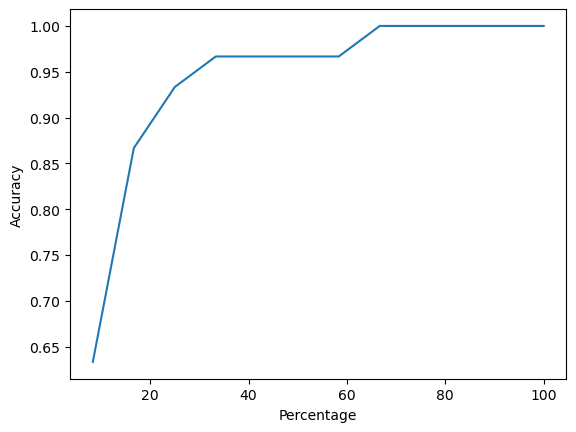

In [148]:
Xdf = df.drop(["species"],axis=1)
Ydf = df["species"]
X_train, X_test, Y_train, Y_test = train_test_split(Xdf, Ydf, random_state=12, stratify=Ydf, test_size=0.2)

Y_test=Y_test.values
X_test=X_test.values
X_train=X_train.values
Y_train=Y_train.values
accuracy_val=[] 
percentageData=[]
for i in range(10,len(X_train)+1,10):
    X=X_train[0:i,:]
    Y=Y_train[0:i]
    tree=makeTree(X,Y,0)
    accuracy=[Y_test[i] == makePrediction(tree,X_test[i]) for i in range(len(Y_test))]
    accuracy_val.append(np.mean(accuracy))
    percentageData.append(100*i/len(X_train))

accuracyDF=pd.DataFrame({"Accuracy":accuracy_val,"Percentage":percentageData})
sb.lineplot(data=accuracyDF, x="Percentage",y="Accuracy")